In [44]:
%load_ext autoreload
%autoreload 2

import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC
from numpyro.infer.util import initialize_model
from numpyro import handlers

# jax.config.update("jax_enable_x64", True)

sys.path.append('../')

from cofilin.forward_model.config import Constants, FMConfig
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.fourier import my_ifft
from cofilin.forward_model.bias import manage_params
from cofilin.forward_model.stats import get_pow_spec_1D, get_pow_spec_quadrupole
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
N, Z_I, Z_F = 256, 99, 0
R = 3.906
L = R * N

cte = Constants(N, L, Z_I, Z_F)

lpt_method = "ALPT"
MND = 1e-2
N_TR = L**3 * MND

det_bias_model = "PowerLaw"
stoch_bias_model = "Poisson"

cweb = "PhiWeb"

fm_cfg = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    N_TR=N_TR,
    rsd=False, 
    lpt_method=lpt_method
)
fmodel = FModel(fm_cfg)

fm_cfg_rsd_plane = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    N_TR=N_TR,
    rsd=True,
    rsd_type='Plane',
    lpt_method=lpt_method
)
fmodel_rsd_plane = FModel(fm_cfg_rsd_plane)

fm_cfg_rsd_rad = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    N_TR=N_TR,
    rsd=True,
    rsd_type='Radial',
    lpt_method=lpt_method
)
fmodel_rsd_rad = FModel(fm_cfg_rsd_rad)

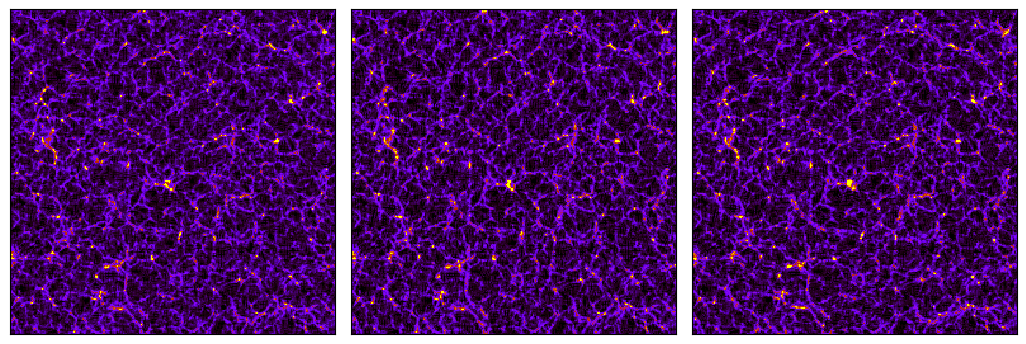

In [49]:
q_data = fmodel.input_arr(jax.random.PRNGKey(1))

delta_lpt = fmodel.delta_lpt(q_data)
delta_lpt_rsd_plane = fmodel_rsd_plane.delta_lpt(q_data)
delta_lpt_rsd_rad = fmodel_rsd_rad.delta_lpt(q_data)

fig, ax = plot_cubes(
    [delta_lpt, delta_lpt_rsd_plane, delta_lpt_rsd_rad],
    cmap=["gnuplot"]*3,
    vlim=[(-1, 10)]*3,
    width=1, axis=2, idx=N//2,
    figsize=7.5
)

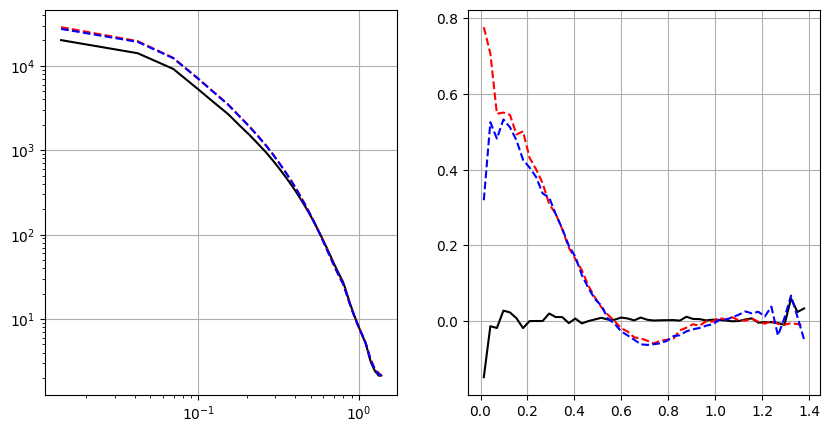

In [50]:
n_bins = 50
ks, pk = get_pow_spec_1D(delta_lpt, L, n_bins)
ks, pk_rsd_plane = get_pow_spec_1D(delta_lpt_rsd_plane, L, n_bins)
ks, pk_rsd_rad = get_pow_spec_1D(delta_lpt_rsd_rad, L, n_bins)

ks, pk_q = get_pow_spec_quadrupole(delta_lpt, L, n_bins, direction='Radial')
ks, pk_q_rsd_plane = get_pow_spec_quadrupole(delta_lpt_rsd_plane, L, n_bins, direction='PlaneParallel')
ks, pk_q_rsd_rad = get_pow_spec_quadrupole(delta_lpt_rsd_rad, L, n_bins, direction='Radial')

fs, rat = 5, 2
fig, axs = plt.subplots(1, 2, figsize=(fs*rat, fs))

axs[0].plot(ks, pk, c='k', ls='-', alpha=1, label=None)
axs[0].plot(ks, pk_rsd_plane, c='r', ls='--', alpha=1, label=None)
axs[0].plot(ks, pk_rsd_rad, c='b', ls='--', alpha=1, label=None)

axs[1].plot(ks, pk_q, c='k', ls='-', alpha=1, label=None)
axs[1].plot(ks, pk_q_rsd_plane, c='r', ls='--', alpha=1, label=None)
axs[1].plot(ks, pk_q_rsd_rad, c='b', ls='--', alpha=1, label=None)


for ax in axs:
    ax.grid(True)

axs[0].set_xscale('log')
axs[0].set_yscale('log')


999.936


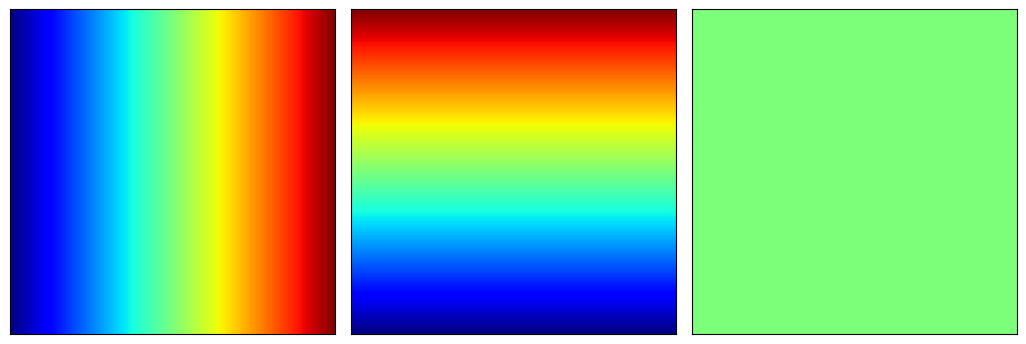

In [ ]:
cte.R
print(cte.L)

axis = (jnp.arange(cte.N) + 0.5) * cte.R - cte.L / 2.0
rx, ry, rz = jnp.meshgrid(axis, axis, axis, indexing="ij")
r2 = rx * rx + ry * ry + rz * rz
                          # avoid r = 0
rinv = 1.0 / jnp.sqrt(r2)

rhat_x = rx * rinv
rhat_y = ry * rinv
rhat_z = rz * rinv

# dot = psi_real[0] * rhat_x + psi_real[1] * rhat_y + psi_real[2] * rhat_z
# psi_real[0] += cte.f1 * dot * rhat_x
# psi_real[1] += cte.f1 * dot * rhat_y
# psi_real[2] += cte.f1 * dot * rhat_z

rhat_x = rx * rinv
rhat_y = ry * rinv
rhat_z = rz * rinv



fig, ax = plot_cubes(
    [rx, ry, rz],
    cmap=["jet"]*3,
    vlim=(-cte.L/2, cte.L/2),
    width=1, axis=2, idx=N//2,
    figsize=7.5
)

# axis[N//2]
# print(axis[0])
# print(axis[-1])